# Data exploration

https://developer.spotify.com/documentation/web-api/reference/

In [3]:
import requests
import time
import config
import json
# import warnings
# warnings.filterwarnings('ignore')
import itertools

# Helper Functions for API Calls

In [1]:
def request_token():
    """
    RETURNS
    -------
    Temporary authorization token necessary to make API calls.
    """
    # Set parameters for the POST request. Based on Spotify OAuth documentation.
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_params = {'grant_type':'client_credentials'}
    auth_header = {'Authorization':f'Basic {config.encoded_key}'}

    # Make request and retrieve a token
    auth_response = requests.post(url = auth_url, data = auth_params,headers=auth_header)
    return auth_response.json()['access_token']

def api_call(kind, token, params = None, id_ = None):
    """
    RETURNS
    -------
    JSON object with API call results.

    PARAMETERS
    -----------
    kind: [str] must be in `allowed kinds` below.

    params: [dict] optional search parameters. Depends on the type of search. Consult
        Spotify API documentation referenced at the top of the notebook for proper input.
        Will be None if id_ is NOT None.

    id_: [str] optional id used for any search requiring an id input. Will be None
        if params is NOT None.

    token: [str] the active OAuth token.
    """
    # Set the allowed kinds of api calls
    allowed_kinds = ['search', 'artist', 'features', 'tracks', 'albums',
                     'album_tracks', 'analysis']

    # Assert that user requested an allowed kind of api call
    assert kind in allowed_kinds, f'Please use from the api call types {allowed_kinds}'

    # Set the appropriate url based on the specified `kind`
    urls = {'search':'search',
            'artists':'artists/',
            'albums':f'artists/{id_}/albums',
            'album_tracks':f'albums/{id_}/tracks',
            'analysis':f'audio-analysis/{id_}',
            'features':f'audio-features/{id_}',
            'tracks':f'tracks/{id_}'}
    
    url = 'https://api.spotify.com/v1/' + urls[kind]

    # Set call authorization
    auth = {'Authorization':f'Bearer {token}'}

    return requests.get(url, params = params, headers = auth).json()

def parse_search(search_results):
    """
    RETURNS
    -------
    The artist id associated with the search result.

    PARAMETERS
    ----------
    search_results: [JSON] the output of the api_call function with 'search'
        used as the first argument.
    """
    return search_results['artists']['items'][0]['id']

def parse_features(features_results):
    """
    RETURNS
    -------
    A dictionary from the analysis_results with only relevant key:value pairs.

    PARAMETERS
    ----------
    features_results: [JSON] the output of the api_call function with 'features'
        used as the first argument.
    """

    # List keys to ignore from features_results
    irrelevant_keys = ['uri','track_href','analysis_url','type']

    # Keep only the key:value pairs we care about
    return {key:features_results[key]
            for key in features_results
            if key not in irrelevant_keys}

def parse_tracks(tracks_results):
    """
    RETURNS
    -------
    A dictionary from the tracks_results with only relevant key:value pairs.
    
    PARAMETERS
    ----------
    tracks_results: [JSON] the output of the api_call function with 'tracks'
        used as the first argument.
    """
    # Empty container for parsed track info
    result = {}

    # Store only the following key:pair info in result
    result['track_name'] = tracks_results['name']
    result['album_name'] = tracks_results['album']['name']
    result['artists'] = [dict_['name']
                         for dict_ in tracks_results['album']['artists']]
    result['release_date'] = tracks_results['album']['release_date']

    return result

In [77]:
token = request_token()

## API CALLS AND PARSING

1. Start with artist names to get Spotify artist IDs
2. Using artist IDs, get up to 50 album IDs per artist
3. Pass Album IDs into album_tracks call to get each individual track's info
4. Pass track ids into analysis, features, and track info calls
5. Maybe MySQL tables? Then can combine necessary things when you want?

In [19]:
"""
1. Start with artist names to get Spotify artist IDs
"""
# Pick artists whose music we'll explore. 4 Salsa, 4 Bachata.
artists = {
    'salsa':["Oscar D'León", "Frankie Ruiz","Tito Nieves", "La Maxima 79"],
    'bachata':["Aventura", "Monchy & Alexandra", "Prince Royce", "Romeo Santos"]
}

def get_artist_ids(artists, token):
    """
    RETURNS
    -------
    A dict with artist ids separated into respective genres. Example:
        {
            'genre_1':{
                'artist_1': 'artist id',
                'artist_2': 'artist id',
                etc.
            },
            'genre_2':{
                'artist_1': 'artist id',
                'artist_2': 'artist id',
                etc.
            },
            etc.
        }
    
    PARAMETERS
    ----------
    artsits: [dict] contains genre and artist information in the form:
        {
            'genre_1':[artist names],
            'genre_2':[artist names],
            etc.
        }
    
    token: [str] The temporary OAuth token obtained from request_token()
        
    """
    
    
    # Container to store artist ids. Depends on number of genres in `artists`
    artist_ids = {genre:{} for genre in artists.keys()}

    # Iterate through each genre and then through each artist name
    for genre, artists in artists.items():
        for artist in artists:

            # Set search params.
            params = {
                  'q':f'{artist}',   # Search Query: [str] spaces must be separated by %20 or +
                  'type':'artist',   # Type of response: [str | comma sep optional] album, artist, playlist, and track
                  'limit':None,      # No. of responses: [int] default is 20. Can be (1, 50)
                  'offset':None      # Index of where to start in the search results. Can be (1, 100,000)
            }

            # Make API call and then parse to append id to artist_ids
            search_results = api_call('search', token, params)
            artist_ids[genre][artist] = parse_search(search_results)
    
    return artist_ids

In [20]:
artist_ids = get_artist_ids(artists, token)

In [21]:
artist_ids

{'salsa': {"Oscar D'León": '1c84wItoiAe1pEbpJMqUmQ',
  'Frankie Ruiz': '4dLvccxeQIM5u80Ri0u9OV',
  'Tito Nieves': '4vOycwLXdkMMzpZW04VW5m',
  'La Maxima 79': '7AcdT1dXIJEStRkbKmwS94'},
 'bachata': {'Aventura': '1qto4hHid1P71emI6Fd8xi',
  'Monchy & Alexandra': '3rs3EOlJ8jyPpdGiQ9Mhub',
  'Prince Royce': '3MHaV05u0io8fQbZ2XPtlC',
  'Romeo Santos': '5lwmRuXgjX8xIwlnauTZIP'}}

In [18]:
for genre, artists in artist_ids.items():
    for artist in artists:
        print(genre, artist, artist_ids[genre][artist])

salsa Oscar D'León 1c84wItoiAe1pEbpJMqUmQ
salsa Frankie Ruiz 4dLvccxeQIM5u80Ri0u9OV
salsa Tito Nieves 4vOycwLXdkMMzpZW04VW5m
salsa La Maxima 79 7AcdT1dXIJEStRkbKmwS94
bachata Aventura 1qto4hHid1P71emI6Fd8xi
bachata Monchy & Alexandra 3rs3EOlJ8jyPpdGiQ9Mhub
bachata Prince Royce 3MHaV05u0io8fQbZ2XPtlC
bachata Romeo Santos 5lwmRuXgjX8xIwlnauTZIP


### Pass these ids into the artist album search to get ids for each album by each artist
Store them in `artists_album_ids`

In [24]:
"""
2. Using artist IDs, get up to 50 album IDs per artist
"""
def get_album_ids(artist_ids, token):
    """
    RETURNS
    -------
    A dict with artists' album ids separated into respective genres. Example:
        {
            'genre_1':{
                'artist_1': [album ids],
                'artist_2': [album ids],
                etc.
            },
            'genre_2': {
                'artist_1': [album ids],
                'artist_2': [album ids],
                etc.
            etc.
            }
        }
    
    PARAMETERS
    ----------
    artsits: [dict] contains genre and artist information in the form:
        {
            'genre_1':[artist names],
            'genre_2':[artist names],
            etc.
        }
    
    token: [str] The temporary OAuth token obtained from request_token(). 
    """

    # Container to store album ids. Depends on number of genres in `artist_ids`
    artist_album_ids = {genre:{} for genre in artist_ids.keys()}

    for genre, artists in artist_ids.items():
        for artist in artists:

            # Capture up to 50 albums by current artist in the loop
            params={'limit':20}

            # Make API call using artist ID of the current artist in the loop
            albums = api_call('albums', token, params=params, id_=artist_ids[genre][artist])

            # Generate list of the album ids for the current artist in the loop. Filter out albums
            # That are not entirely their own by restricting the album artist name to be only the name
            # of the current artist in the loop
            album_ids = [album['id']
                         for album in albums['items']
                         if album['artists'][0]['name'] == artist]

            # Add this list to a dict
            artist_album_ids[genre][artist] = album_ids

            # Wait a little bit to not get kicked off API
            time.sleep(0.25)

    return artist_album_ids

In [25]:
artist_album_ids = get_album_ids(artist_ids, token)

In [26]:
artist_album_ids

{'salsa': {"Oscar D'León": ['0fzFT0YUr6QoRUakLPyb3f',
   '1ESXDx2MI2QGcxTZXaAfRH',
   '6f1DXy5ZSRNaeMS2iNdIdg',
   '18xuM1CT09XHl1BtVOdO8S',
   '1zL9QFj24ZTmTED7WEmSoD',
   '5bNCf8kQhDnamhJROfN6P5',
   '4Ot2EmYr5mX1UEjn2y0C1s',
   '7Ar5mioYg8BZRlCUigEyYp',
   '4UeTedugXFJDbHojmiyipe',
   '6PgX4BHyNOch6q5as70jYl',
   '7xeqTWPwEqxxrdYX5aKDjp',
   '4lFzQHuobt31jHlY1JqAu4',
   '5fafspFuykiPurGr6Cmxo5',
   '3NyonPf81f2SD8WxnfIdKT',
   '5uoST6sL0bQP7md1q3mbDa'],
  'Frankie Ruiz': ['7kt8nJfzerlsCFzYyFiuz5',
   '6rfEtnxDegQeLJgRrO77oK',
   '3zo6RSGkyKQSwViQEw6P6F',
   '1vwpCJWTBtfNhtNfTGnXXN',
   '662mT9hSJWYCUfoXJSD3hl',
   '3Z6vQrgSvAWvhvgDLEE0l3',
   '496OpYfhIiO5B5K2vdMGfo',
   '7qVMjFoNbVzaUwU2vapE9h',
   '50yNgXCHV2yhDkFNEVXH7E',
   '6g0qVU3bgnwtso9iU2qp8a',
   '1xg71u8jtkF693PyfY7LlO',
   '7hcypDZa93AschBatm9b8X',
   '5DQZ3PvVMUNavIEAcAHLRi',
   '4I0GURNIly2aPl4KIqKDvU',
   '0bdO1op5hTgpJhBsVB63lo',
   '0mtjqZD5smyhtNB5GBxxC8',
   '6qoMINAYrz4P1bT6jOrvlQ',
   '5MVIEXplMunTSkd5xOgI2J',
 

In [28]:
count = 0
for genre, artists in artist_album_ids.items():
    for artist in artists:
        count += len(artist_album_ids[genre][artist])
count

129

We have 129 albums from these 8 artists (wow).

### Pass ids into multiple album call

In [29]:
for genre, artists in artist_album_ids.items():
    for artist in artists:
        

salsa Oscar D'León ['0fzFT0YUr6QoRUakLPyb3f', '1ESXDx2MI2QGcxTZXaAfRH', '6f1DXy5ZSRNaeMS2iNdIdg', '18xuM1CT09XHl1BtVOdO8S', '1zL9QFj24ZTmTED7WEmSoD', '5bNCf8kQhDnamhJROfN6P5', '4Ot2EmYr5mX1UEjn2y0C1s', '7Ar5mioYg8BZRlCUigEyYp', '4UeTedugXFJDbHojmiyipe', '6PgX4BHyNOch6q5as70jYl', '7xeqTWPwEqxxrdYX5aKDjp', '4lFzQHuobt31jHlY1JqAu4', '5fafspFuykiPurGr6Cmxo5', '3NyonPf81f2SD8WxnfIdKT', '5uoST6sL0bQP7md1q3mbDa']
salsa Frankie Ruiz ['7kt8nJfzerlsCFzYyFiuz5', '6rfEtnxDegQeLJgRrO77oK', '3zo6RSGkyKQSwViQEw6P6F', '1vwpCJWTBtfNhtNfTGnXXN', '662mT9hSJWYCUfoXJSD3hl', '3Z6vQrgSvAWvhvgDLEE0l3', '496OpYfhIiO5B5K2vdMGfo', '7qVMjFoNbVzaUwU2vapE9h', '50yNgXCHV2yhDkFNEVXH7E', '6g0qVU3bgnwtso9iU2qp8a', '1xg71u8jtkF693PyfY7LlO', '7hcypDZa93AschBatm9b8X', '5DQZ3PvVMUNavIEAcAHLRi', '4I0GURNIly2aPl4KIqKDvU', '0bdO1op5hTgpJhBsVB63lo', '0mtjqZD5smyhtNB5GBxxC8', '6qoMINAYrz4P1bT6jOrvlQ', '5MVIEXplMunTSkd5xOgI2J', '0E4pPiiu07zWuHuL0vBhyY', '0c4wf1zsEMYxgMuz9J0gnf']
salsa Tito Nieves ['0xirfmF6ujKSXUFWR2lBHQ', '44Ba

In [30]:
artist_album_ids['salsa']['La Maxima 79']

['7qT8IlanvvGFWficDVlypX',
 '6KZ82LfPT6zzlqX6wldk54',
 '6hu4s5s92lZdXscKK45aaX',
 '3RfkGYBWkRwusACOgg7fuu',
 '07xuhacpsoNU4I271LJ6Rq',
 '6oqb27X6zAhuRiTseDIeKx',
 '25RNGMXTiRLBF5BbPLFwYS',
 '3LkyYGOI0iAp2eSdDiKa8y']

In [43]:
def get_track_ids(artist_album_ids, token):
    """
    RETURNS
    -------
    A dict with all the track ids separated into respective genres. Example:
        {
            'genre_1':[track ids],
            'genre_2':[track ids],
            etc.
            }
        }
        
    Note, no longer keeping track of artist names since it just adds more
    layers of iteration later.
    
    PARAMETERS
    ----------
    artist_album_ids: [dict] artists' album ids separated into respective genres. The output
    of get_album_ids(). Example:
        
        {
            'genre_1':{
                'artist_1': [album ids],
                'artist_2': [album ids],
                etc.
            },
            'genre_2': {
                'artist_1': [album ids],
                'artist_2': [album ids],
                etc.
            etc.
            }
        }
    
    token: [str] The temporary OAuth token obtained from request_token().
    """
    
    # Container to store track ids. Depends on number of genres in `artist_album_ids`
    genre_track_ids = {genre:[] for genre in artist_album_ids.keys()}

    # Iterate through the dict to get an individual artist's albums
    for genre, artists in artist_album_ids.items():
        for artist in artists:
            for album_id in artist_album_ids[genre][artist]:

                # Call API for album track info
                tracks = api_call('album_tracks', token, id_=album_id)

                # Iterate through each album's track's info to append track ids
                for track in tracks['items']:
                    genre_track_ids[genre].append(track['id'])

            # Wait a moment
            time.sleep(0.1)
    
    return genre_track_ids

In [44]:
track_ids = get_track_ids(artist_album_ids, token)

In [50]:
track_ids.keys()

dict_keys(['salsa', 'bachata'])

In [51]:
one_features = api_call('features', token, id_=track_ids['salsa'][0])

In [55]:
one_features

{'danceability': 0.829,
 'energy': 0.702,
 'key': 4,
 'loudness': -9.681,
 'mode': 0,
 'speechiness': 0.0606,
 'acousticness': 0.509,
 'instrumentalness': 3.2e-06,
 'liveness': 0.053,
 'valence': 0.761,
 'tempo': 99.989,
 'type': 'audio_features',
 'id': '7J23B2HdvhvZvCM7hyv7ic',
 'uri': 'spotify:track:7J23B2HdvhvZvCM7hyv7ic',
 'track_href': 'https://api.spotify.com/v1/tracks/7J23B2HdvhvZvCM7hyv7ic',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7J23B2HdvhvZvCM7hyv7ic',
 'duration_ms': 259240,
 'time_signature': 4}

In [54]:
parse_features(one_features

{'danceability': 0.829,
 'energy': 0.702,
 'key': 4,
 'loudness': -9.681,
 'mode': 0,
 'speechiness': 0.0606,
 'acousticness': 0.509,
 'instrumentalness': 3.2e-06,
 'liveness': 0.053,
 'valence': 0.761,
 'tempo': 99.989,
 'id': '7J23B2HdvhvZvCM7hyv7ic',
 'duration_ms': 259240,
 'time_signature': 4}

In [63]:
one_track = api_call('tracks', token, id_=track_ids['salsa'][0])

In [67]:
parse_tracks(one_track)

{'track_name': 'El Regalito',
 'album_name': 'No Volveré',
 'artists': ["Oscar D'León"],
 'release_date': '2019-11-20'}

In [57]:
one_sections = api_call('analysis', token, id_=track_ids['salsa'][0])

In [72]:
one_sections.keys()

dict_keys(['meta', 'track', 'bars', 'beats', 'tatums', 'sections', 'segments'])

In [73]:
one_sections['sections']

[{'start': 0.0,
  'duration': 19.63042,
  'confidence': 1.0,
  'loudness': -17.249,
  'tempo': 99.918,
  'tempo_confidence': 0.87,
  'key': 9,
  'key_confidence': 0.446,
  'mode': 0,
  'mode_confidence': 0.403,
  'time_signature': 4,
  'time_signature_confidence': 0.967},
 {'start': 19.63042,
  'duration': 26.99095,
  'confidence': 0.836,
  'loudness': -10.429,
  'tempo': 100.062,
  'tempo_confidence': 0.594,
  'key': 9,
  'key_confidence': 0.558,
  'mode': 0,
  'mode_confidence': 0.447,
  'time_signature': 4,
  'time_signature_confidence': 1.0},
 {'start': 46.62138,
  'duration': 10.9055,
  'confidence': 0.365,
  'loudness': -9.722,
  'tempo': 99.03,
  'tempo_confidence': 0.633,
  'key': 7,
  'key_confidence': 0.198,
  'mode': 1,
  'mode_confidence': 0.432,
  'time_signature': 4,
  'time_signature_confidence': 1.0},
 {'start': 57.52687,
  'duration': 13.84944,
  'confidence': 0.393,
  'loudness': -12.09,
  'tempo': 99.794,
  'tempo_confidence': 0.556,
  'key': 1,
  'key_confidence': 0

In [79]:
def collect_data(track_ids):
    """
    Returns a list of song data for each id passed into the function.
    Param track_ids: [list of strings] must be valid Spotify song IDs.
    """
    
    # Container for song data
    result = []
    
    # Iterate through track id list
    for track_id in track_ids:
        
#         print('start of the loop')
#         print(f'track id is {track_id}')

        # Call API for section data. See documentation for meanings
        analysis_sections = {'sections':api_call('analysis', token, id_=track_id)['sections']}
        
        # Call API for audio features and parse for relevant information
        parsed_features = parse_features(api_call('features', token, id_=track_id))
        
        # Call API for track info and parse for relevant information
        parsed_track_info = parse_tracks(api_call('tracks', token, id_=track_id))
        
        # Combine all these calls into a single dict, adding in genre
        row = {**parsed_features, **parsed_track_info, **analysis_sections,'genre':genre}
        
        # Append to container
        result.append(row)
        
        break
        time.sleep(0.1)
        
    return result

In [80]:
test = collect_data(track_ids['salsa'])

In [81]:
test

[{'danceability': 0.829,
  'energy': 0.702,
  'key': 4,
  'loudness': -9.681,
  'mode': 0,
  'speechiness': 0.0606,
  'acousticness': 0.509,
  'instrumentalness': 3.2e-06,
  'liveness': 0.053,
  'valence': 0.761,
  'tempo': 99.989,
  'id': '7J23B2HdvhvZvCM7hyv7ic',
  'duration_ms': 259240,
  'time_signature': 4,
  'track_name': 'El Regalito',
  'album_name': 'No Volveré',
  'artists': ["Oscar D'León"],
  'release_date': '2019-11-20',
  'sections': [{'start': 0.0,
    'duration': 19.63042,
    'confidence': 1.0,
    'loudness': -17.249,
    'tempo': 99.918,
    'tempo_confidence': 0.87,
    'key': 9,
    'key_confidence': 0.446,
    'mode': 0,
    'mode_confidence': 0.403,
    'time_signature': 4,
    'time_signature_confidence': 0.967},
   {'start': 19.63042,
    'duration': 26.99095,
    'confidence': 0.836,
    'loudness': -10.429,
    'tempo': 100.062,
    'tempo_confidence': 0.594,
    'key': 9,
    'key_confidence': 0.558,
    'mode': 0,
    'mode_confidence': 0.447,
    'time_sig

In [15]:
salsa_track_data = collect_data(salsa_track_ids,'salsa')

In [19]:
bachata_track_data = collect_data(bachata_track_ids,'bachata')

In [20]:
all_track_data = salsa_track_data + bachata_track_data

## Import into DF

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [22]:
df = pd.DataFrame(all_track_data)

In [23]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,track_name,album_name,artists,release_date,sections,genre
0,0.829,0.702,4,-9.681,0,0.0606,0.509,0.000003,0.0530,0.761,99.989,7J23B2HdvhvZvCM7hyv7ic,259240,4,El Regalito,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 19.63042, 'confide...",salsa
1,0.614,0.433,0,-11.940,1,0.0741,0.498,0.000006,0.1650,0.674,118.049,3fS3Uc3P823QWJozrbt4Q0,248680,4,No Volveré,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 8.28078, 'confiden...",salsa
2,0.827,0.711,8,-10.970,1,0.0501,0.356,0.000003,0.0535,0.965,97.559,4xIMgxIq1iaKdSNEToN2Bx,220027,4,Enamoraito,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 26.93821, 'confide...",salsa
3,0.795,0.779,9,-10.642,0,0.1120,0.340,0.000010,0.1290,0.830,102.962,1w4ExH2EpK0nUpRtD2TfFC,253013,4,Llámame,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 9.06153, 'confiden...",salsa
4,0.803,0.470,2,-10.782,1,0.0402,0.433,0.000000,0.0872,0.786,119.960,2pHYBVtJ9cTYkQPPZVFav7,237813,4,Corazón Gitano,No Volveré,[Oscar D'León],2019-11-20,"[{'start': 0.0, 'duration': 17.32051, 'confide...",salsa


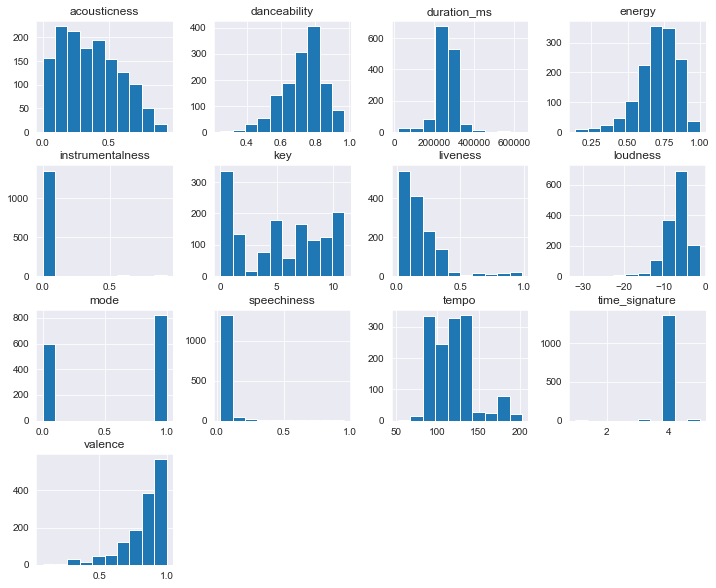

In [24]:
df.hist(figsize=(12,10));

Let's remove songs with time signature != 4. Bachata and salsa is always in 4.

In [25]:
# Get names of indexes for which time signature isn't 4
indexNames = df[df['time_signature'] != 4].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames, inplace=True)

### Audio Analysis Feature Engineering

In [26]:
def avg_section_duration(sections):
    """
    Returns the average section duration of a Spotify track.
    Param sections: [list] section object obtained from Spotify API. 
    """
    total = 0
    for section in sections:
        total += section['duration']
    return total/len(sections)

In [27]:
avg_section_duration(df.iloc[0].sections)

19.94153769230769

In [28]:
df['no_of_sectionss'] = df['sections'].map(lambda sections: len(sections))
df['avg_section_len'] = df['sections'].map(lambda sections: avg_section_duration(sections)) 

In [29]:
salsa_df, bachata_df = df[df['genre'] == 'salsa'], df[df['genre'] == 'bachata']

### Salsa Attributes

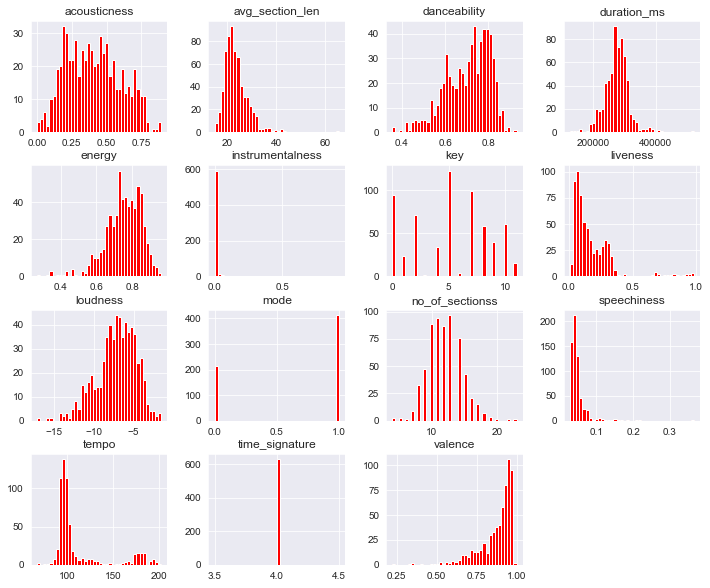

In [34]:
salsa_df.hist(figsize=(12,10),label='Salsa track attributes',bins=40,color='red');

### Bachata Attributes

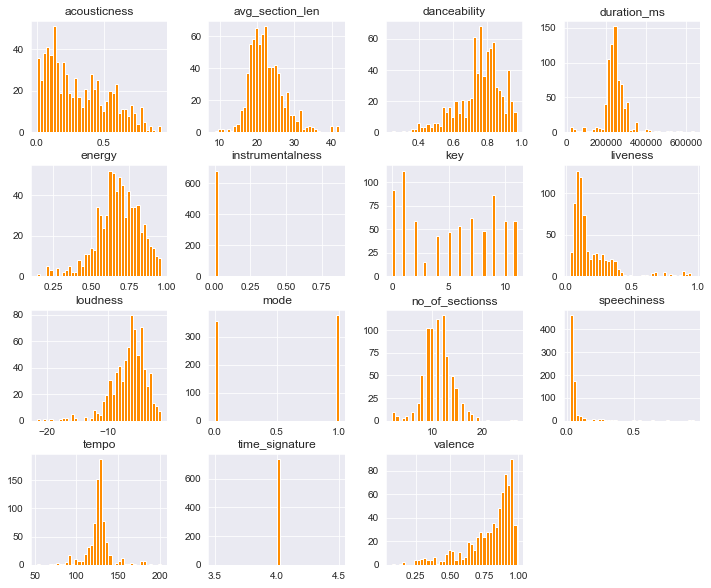

In [35]:
bachata_df.hist(figsize=(12,10),label='Bachata track attributes',bins=40,color='darkorange');

### Some side-by-side comparisons

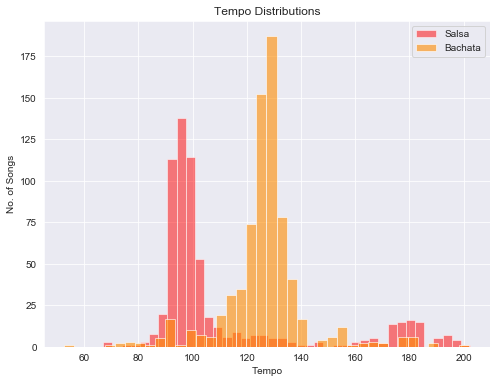

In [36]:
fig = plt.figure(figsize=(8,6))
plt.hist(salsa_df['tempo'],bins=40, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['tempo'],bins = 40, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('Tempo')
plt.ylabel('No. of Songs')
plt.title('Tempo Distributions')
plt.show()

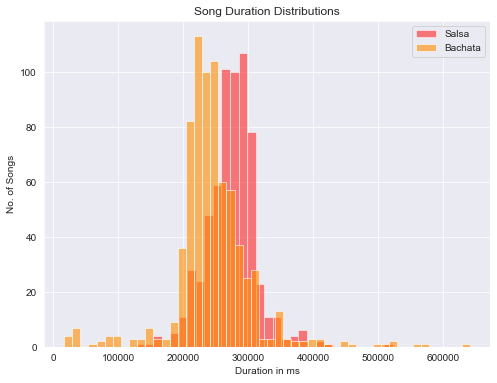

In [37]:
fig = plt.figure(figsize=(8,6))
plt.hist(salsa_df['duration_ms'],bins = 30, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['duration_ms'],bins = 50, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('Duration in ms')
plt.ylabel('No. of Songs')
plt.title('Song Duration Distributions')
plt.show()

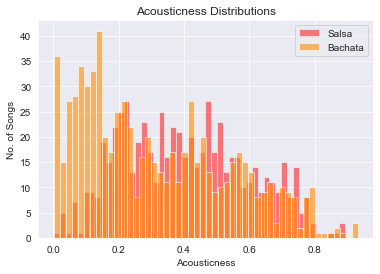

In [38]:
plt.hist(salsa_df['acousticness'],bins = 50, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['acousticness'],bins = 50, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('Acousticness')
plt.ylabel('No. of Songs')
plt.title('Acousticness Distributions')
plt.show()

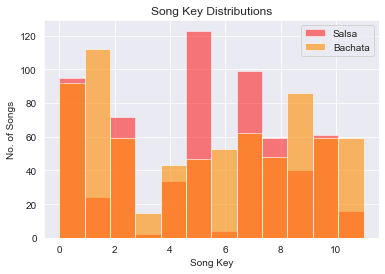

In [39]:
plt.hist(salsa_df['key'],bins = 12, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['key'],bins = 12, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('Song Key')
plt.ylabel('No. of Songs')
plt.title('Song Key Distributions')
plt.show()

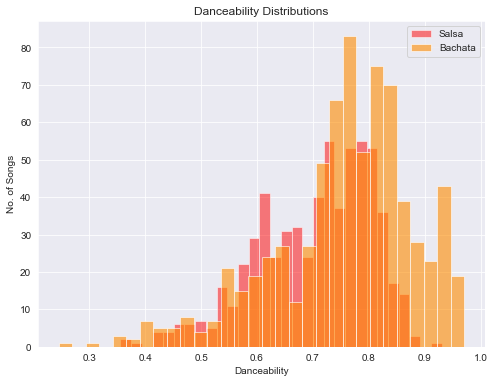

In [40]:
fig = plt.figure(figsize=(8,6))
plt.hist(salsa_df['danceability'],bins = 30, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['danceability'],bins = 30, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('Danceability')
plt.ylabel('No. of Songs')
plt.title('Danceability Distributions')
plt.show()

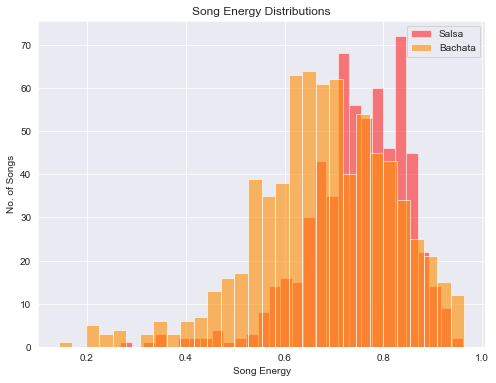

In [41]:
fig = plt.figure(figsize=(8,6))
plt.hist(salsa_df['energy'],bins = 30, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['energy'],bins = 30, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('Song Energy')
plt.ylabel('No. of Songs')
plt.title('Song Energy Distributions')
plt.show()

### Final preprocessing - encoding of genre

In [42]:
df['is_salsa'] = df['genre'].map(lambda x: 1 if x == 'salsa' else 0)

In [43]:
df.to_csv('cleaned_data.csv',index=False)

In [102]:
df_export = df.drop(['no_of_sectionss','avg_section_len','is_salsa'],axis=1)

In [103]:
import pickle

with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(df_export, f, pickle.HIGHEST_PROTOCOL)

## Modeling

In [75]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [46]:
# List of predictors that we want to include in the model
predictors = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
              'duration_ms', 'no_of_sectionss', 'avg_section_len']

# Same list as above but remove the two engineered features
predictors_no_engineered = list(filter(lambda x: x not in ['no_of_sectionss','avg_section_len'],predictors))

# Model target
target = ['is_salsa']

In [47]:
# Train-test split for data excluding engineered features
X = df.loc[:, predictors_no_engineered]
y = df.loc[:, target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# Train-test split for data including engineered features
X_eng = df.loc[:, predictors]
y_eng = df.loc[:, target]

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size = 0.3, random_state = 1)

## Decision Tree GS

In [52]:
def decision_tree_gs(X_train, X_test, y_train, y_test):
    """
    Runs GridSearch CV on various parameters for a decision tree on a set of data.
    
    Returns the mean test score.
    """
    
    # Create the classifier, fit it on the training data and make predictions on the test set
    dt_clf = DecisionTreeClassifier(random_state=1)

    # GridSearch CV grid parameters
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 3, 4, 5, 6],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 3, 4, 5, 6]
    }

    # Instantiate GS and fit
    dt_grid_search = GridSearchCV(dt_clf, param_grid, cv=3, return_train_score=True)
    dt_grid_search.fit(X_train, y_train)

    # Mean training score
    dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

    # Mean test score
    dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

#     print(f"Mean Training Score: {dt_gs_training_score :.2%}")
#     print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
    print(f"Optimal Parameters: {dt_grid_search.best_params_}")
    
    return dt_gs_testing_score

## Random Forest GS

In [50]:
def random_forest_gs(X_train, X_test, y_train, y_test):
    """
    Runs GridSearch CV on various parameters for a random forest model on a set of data.
    
    Returns the mean test score.
    """

    rf_clf = RandomForestClassifier(random_state=1)

    rf_param_grid = {
        'n_estimators': [10, 30, 100],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 6, 10],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [3, 6]
    }

    rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
    rf_grid_search.fit(X_train, y_train)

#     print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
#     print(f"Testing: {rf_grid_search.score(X_test, y_test) :.2%}")
    print(f"Optimal Parameters: {rf_grid_search.best_params_}")
    
    return rf_grid_search.score(X_test, y_test)

## Running comparison between tree and forest models w engineered features vs. non engineered features

In [53]:
print('Decision tree grid search without engineered features: ', decision_tree_gs(X_train, X_test, y_train, y_test))
print("")
print('Random forest grid search without engineered features: ', random_forest_gs(X_train, X_test, y_train, y_test))

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 2}
Decision tree grid search without engineered features:  0.9170731707317074



/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}
Random forest grid search without engineered features:  0.9390243902439024


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [54]:
print('Decision tree grid search with engineered features: ', decision_tree_gs(X_train_eng, X_test_eng, y_train_eng, y_test_eng))
print("")
print('Random forest grid search with engineered features: ', random_forest_gs(X_train_eng, X_test_eng, y_train_eng, y_test_eng))

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision tree grid search with engineered features:  0.9121951219512195



/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y wa

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 30}
Random forest grid search with engineered features:  0.9195121951219513


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The results of these grid searches show us that the the engineered features actually lower the accuracy of the model. This is interesting, as it suggests that the audio analysis data is inaccurate. I played a song and compared how Spotify classifies "sections" versus what a musician would perceive as a musical phrase, and I found several inconsitencies. Often times Spotify's algorithm fails to recognize a new musical phrase or will completely mischaracterize the start of a new phrase. This means that any inferences I attempted to engineer were not accurate and cannot actually be achieved by Spotify's current audio analysis data. I would need to generate that data myself, which I don't have time to do under the time constraints of this project.

Looking below, the distributions of these variables also clearly show a tremendous amount of overlap between these variables. It makes sense why the model could not distinguish well between them.

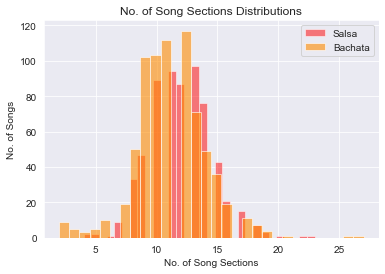

In [55]:
plt.hist(salsa_df['no_of_sectionss'],bins = 30, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['no_of_sectionss'],bins = 30, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('No. of Song Sections')
plt.ylabel('No. of Songs')
plt.title('No. of Song Sections Distributions')
plt.show()

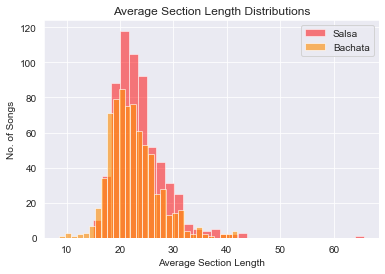

In [56]:
plt.hist(salsa_df['avg_section_len'],bins = 30, alpha=0.5, label='Salsa',color='red')
plt.hist(bachata_df['avg_section_len'],bins = 30, alpha=0.6, label='Bachata',color='darkorange')
plt.legend(loc='upper right')
plt.xlabel('Average Section Length')
plt.ylabel('No. of Songs')
plt.title('Average Section Length Distributions')
plt.show()

## Anyway

The conditions for the best model (random forest w/ no engineered features): `{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}`

Let's thus generate a random forest and begin to make some sense of it.

## Underperforming Tree/Forest Models

In [48]:
# Create models based on above parameters other than the non-engineered random forest. These are just to have 
# for later comparison against other models

tree_no_eng = DecisionTreeClassifier(criterion='entropy',
                                max_depth=None,
                                min_samples_leaf=3,
                                min_samples_split=5,
                                random_state=1)

tree_eng = DecisionTreeClassifier(criterion='entropy',
                                max_depth=None,
                                min_samples_leaf=3,
                                min_samples_split=5,
                                random_state=1)

forest_eng = RandomForestClassifier(criterion='entropy',
                                max_depth=None,
                                min_samples_leaf=3,
                                min_samples_split=5,
                                n_estimators=30,
                                random_state=1)

tree_no_eng.fit(X_train,y_train);
tree_eng.fit(X_train_eng, y_train_eng);
forest_eng.fit(X_train_eng, y_train_eng);

y_pred_tree_no_eng = tree_no_eng.predict(X_test)
y_pred_tree_eng = tree_eng.predict(X_test_eng)
y_pred_forest_eng = forest_eng.predict(X_test_eng)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


## Random Forest (best model)

In [57]:
forest_no_eng = RandomForestClassifier(criterion='entropy',
                                max_depth=None,
                                min_samples_leaf=3,
                                min_samples_split=5,
                                n_estimators=30,
                                random_state=1)

forest_no_eng.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

### Forest Confusion Matrix

[[214   7]
 [ 18 171]]


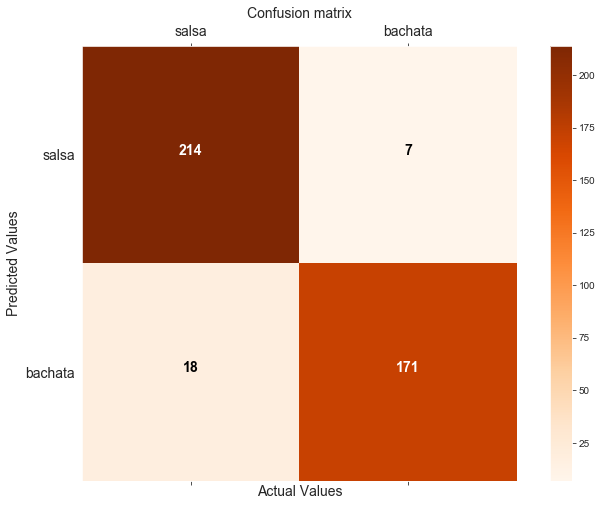

In [58]:
# Generate predicted y values from test data
y_pred_forest_no_eng = forest_no_eng.predict(X_test)

# Create CM
cm = confusion_matrix(y_test,y_pred_forest_no_eng)
classes = ['salsa','bachata']
print(cm)

# Create fig, ax, and plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap=plt.cm.Oranges)
fig.colorbar(cax)

# Apply labels
plt.title('Confusion matrix',fontdict={'size':14})
ax.set_xticklabels([''] + classes,fontdict={'size':14})
ax.set_yticklabels([''] + classes,fontdict={'size':14})
plt.xlabel('Actual Values',fontdict={'size':14})
plt.ylabel('Predicted Values',fontdict={'size':14})

# Remove grid lines
plt.grid(b=None)

# Apply text
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             fontdict={'size':14,'weight':'heavy'},
             color="white" if cm[i, j] > thresh else "black")
plt.show()

### Forest Feature Importances

In [59]:
def plot_feature_importances(model):
    """
    Plots the feature importances of the given model
    """
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center',color='darkorange') 
    plt.yticks(np.arange(n_features), X_train.columns.map(lambda x: x.title()).values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Model Feature Importances')

In [61]:
forest_no_eng.feature_importances_

array([0.09591267, 0.08054347, 0.01731671, 0.0488102 , 0.01106705,
       0.05879854, 0.05788657, 0.03010288, 0.04250251, 0.0627356 ,
       0.34694816, 0.14737565])

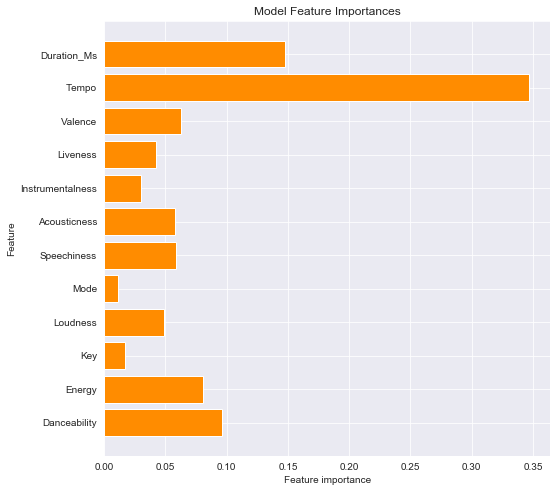

In [62]:
plot_feature_importances(forest_no_eng)

Tempo, duration, danceability, and energy seem to be the top 4 predictors.

### F1 Score

In [63]:
#calculating the F1 score
2*(metrics.precision_score(y_test, y_pred_forest_no_eng)*metrics.recall_score(y_test, y_pred_forest_no_eng))/(metrics.precision_score(y_test, y_pred_forest_no_eng)+metrics.recall_score(y_test, y_pred_forest_no_eng))

0.9318801089918257

### Examining incorrect model predictions

My first inclination is that the genres have been incorrectly tagged by the album, as they are assigned at the album level. A quick examination (and familiarity with the music) suggests that the genre tags are correct. My next hunch is to look at the variables which have greatest importance in the model. I predict salsa songs incorrectly predicted will simply exhibit traits of bachata songs in tempo, duration, danceability, and/or energy. Vice versa with bachata. 

In [69]:
# reshape test values
test_values = (y_test.values).reshape(1,-1)[0]

# find list indices of incorrect predictions
wrong_pred_indices = [i for i in range(len(test_values)) if test_values[i] != y_pred_forest_no_eng[i]]

# find dataframe indices of incorrect predictions 
df_indices = y_test.reset_index().iloc[wrong_pred_indices,:]['index'].values

# Select only the columns we want to inspect
columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
           'duration_ms', 'track_name', 'album_name', 'artists', 'genre']

# Create dataframe that includes ONLY songs that were incorrectly classified
incorrect_df = df.loc[df_indices,columns]

incorrect_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_name,album_name,artists,genre
94,0.603,0.427,5,-12.174,0,0.0305,0.654,0.000239,0.672,0.602,116.610,160888,Obsesión,El Diablo de la Salsa: Muchos Más,[Oscar D'León],salsa
1166,0.668,0.761,1,-6.618,0,0.0306,0.160,0.000000,0.159,0.725,102.040,258600,Close to You,Phase II,[Prince Royce],bachata
104,0.651,0.645,7,-11.023,1,0.0370,0.627,0.000769,0.318,0.900,147.470,281600,Sandunguera,Hits del Double Play,[Oscar D'León],salsa
655,0.726,0.705,9,-8.184,0,0.2740,0.518,0.000000,0.238,0.710,175.926,267787,Ella y Yo (feat. Don Omar),Todavía Me Amas: Lo Mejor de Aventura,[Aventura],bachata
526,0.765,0.719,10,-6.314,0,0.0488,0.296,0.000000,0.240,0.890,110.034,222267,Por Eso Estoy Contigo,Mi Ultima Grabacion,[Tito Nieves],salsa


### Comparing attributes of incorrectly predicted songs to average attributes of the full dataset

I predict the songs that were incorrectly classified have song attributes that fall  in  regions where it is difficult to distinguish between the genres.

In [99]:
tempo_comp = pd.concat([pd.DataFrame(df.groupby('genre').agg({'tempo':'mean'})),pd.DataFrame(incorrect_df.groupby('genre').agg({'tempo':'mean'}))],axis=1)
tempo_comp.columns = ['Tempo - Full Dataset','Tempo - Incorrect Predictions']
tempo_comp

,Tempo - Full Dataset,Tempo - Incorrect Predictions
genre,,
bachata,126.399211,130.296714
salsa,111.137073,130.785611


In [71]:
duration_comp = pd.concat([pd.DataFrame(df.groupby('genre').agg({'duration_ms':'mean'})),pd.DataFrame(incorrect_df.groupby('genre').agg({'duration_ms':'mean'}))],axis=1)
duration_comp.columns = ['Full Dataset Duration','Incorrect Duration Predictions']
duration_comp

,Full Dataset Duration,Incorrect Duration Predictions
genre,,
bachata,244339.291156,296536.142857
salsa,275220.996820,233145.833333


In [72]:
danceability_comp = pd.concat([pd.DataFrame(df.groupby('genre').agg({'danceability':'mean'})),pd.DataFrame(incorrect_df.groupby('genre').agg({'danceability':'mean'}))],axis=1)
danceability_comp.columns = ['Full Dataset Danceability','Incorrect Danceability Predictions']
danceability_comp

,Full Dataset Danceability,Incorrect Danceability Predictions
genre,,
bachata,0.755850,0.681286
salsa,0.702728,0.713833


In [73]:
energy_comp = pd.concat([pd.DataFrame(df.groupby('genre').agg({'energy':'mean'})),pd.DataFrame(incorrect_df.groupby('genre').agg({'energy':'mean'}))],axis=1)
energy_comp.columns = ['Full Dataset Energy','Incorrect Energy Predictions']
energy_comp

,Full Dataset Energy,Incorrect Energy Predictions
genre,,
bachata,0.678786,0.751143
salsa,0.747730,0.660889


## Experimenting with PCA

Standard scale and then run the analysis.

In [76]:
X_scaled = StandardScaler().fit_transform(X_train)

pca_1 = PCA()

In [77]:
principalComponents = pca_1.fit_transform(X_scaled)

print(pca_1.explained_variance_ratio_)

pca_1.components_[0]

[0.17398706 0.1325073  0.10456524 0.09365031 0.08397151 0.08292221
 0.07561888 0.06878145 0.06593203 0.05324465 0.04681239 0.01800697]


array([-0.18643143, -0.47401581, -0.02222488, -0.50101863, -0.11448467,
        0.47481793,  0.22253163,  0.03860482,  0.14800599, -0.30333133,
       -0.04007945, -0.28973647])

In [78]:
structure_loading_1 = pca_1.components_[0]* np.sqrt(pca_1.explained_variance_)
str_loading_1 = pd.DataFrame(structure_loading_1, index=X_train.columns)
str_loading_1.columns = ['Loading']

In [79]:
str_loading_1

,Loading
danceability,-0.269523
energy,-0.598041
key,-0.024909
loudness,-0.531406
mode,-0.114982
speechiness,0.473894
acousticness,0.212092
instrumentalness,0.035091
liveness,0.131718
valence,-0.242590


The above reflects the relative amount of variance in the overall component that is explained by each of the variables. speechiness, acousticness, instrumentalness, and liveness all are correlated in the same direction. This makes sense. It also makes sense that valence, tempo, mode, energy, and danceability are correlated in the same direction. Key and tempo don't really correlate much with those other variables in real life. They're pretty independent, so I think it's fair that their magnitudes are smaller.

Now that we have some interpretation of our PCA, let's use it in a pipeline and see if it influences our random forest.

In [80]:
from sklearn.pipeline import Pipeline

# Construct pipeline
pipe_rf = Pipeline([('scl', MinMaxScaler()),
                    ('pca', PCA()),
                    ('clf', RandomForestClassifier(random_state=1))])

# Construct parameter grid
rf_param_grid = [{'clf__n_estimators': [120],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
   'clf__min_samples_split':[0.05 ,0.1, 0.2]
  }]

# Construct grid search
pipe_rf_grid_search = GridSearchCV(estimator=pipe_rf,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
pipe_rf_grid_search.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % pipe_rf_grid_search.best_score_)

# Best params
print('\nBest params:\n', pipe_rf_grid_search.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 


/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:   45.8s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
Best accuracy: 0.873

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 120}


PCA RF pipeline achieves best accuracy of 0.873. This is 10% less accuracy than the non-PCA-transformed data. We will abandon this method.

## Logistic Regression
Start with min-max scaling and then fit regression

In [81]:
X_train_mm_scaled = MinMaxScaler().fit_transform(X_train)
 
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_mm_scaled, y_train)
model_log

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Now we have model so let's predict

In [82]:
X_test_mm_scaled = MinMaxScaler().fit_transform(X_test)

y_hat_test = logreg.predict(X_test_mm_scaled)
y_hat_train = logreg.predict(X_train_mm_scaled)

In [83]:
# We could subtract the two columns. If values or equal, difference will be zero. Then count number of zeros 
residuals = np.abs((y_train_eng.values).reshape(1,-1)[0] - y_hat_train)

In [84]:
print(pd.Series(residuals).value_counts())
# print(pd.Series(residuals).value_counts(normalize=True))

print(f"Log model predicts training data {round(815/(954),2)*100}% of the time")

0    814
1    140
dtype: int64
Log model predicts training data 85.0% of the time


In [86]:
residuals = np.abs((y_test_eng.values).reshape(1,-1)[0] - y_hat_test)
print(pd.Series(residuals).value_counts())
# print(pd.Series(residuals).value_counts(normalize=True))

print(f"Log model predicts training data {round(336/(410),2)*100}% of the time")

0    336
1     74
dtype: int64
Log model predicts training data 82.0% of the time


In [87]:
y_pred_log = logreg.predict(X_test_mm_scaled)

### Comparing Models

In [92]:
#getting matrix with Weighted Scores
def evaluate(test, pred, model):
    return [model, 
            round(accuracy_score(test, pred),3),
            round(precision_score(test, pred),3), 
            round(recall_score(test, pred),3),
            round(f1_score(test, pred),3)]

In [96]:
tree_no_eng_eval = evaluate(y_test,y_pred_tree_no_eng,'Decision Tree No Engineered Features')
forest_no_eng_eval = evaluate(y_test,y_pred_forest_no_eng,'Random Forest No Engineered Features')
tree_eng_eval = evaluate(y_test,y_pred_tree_eng,'Decision Tree With Engineered Features')
forest_eng_eval = evaluate(y_test,y_pred_forest_eng,'Random Forest With Engineered Features')
log_eval = evaluate(y_test,y_pred_log,'Logistic Regression')

results_weighted= pd.DataFrame()
results_weighted= results_weighted.append([tree_no_eng_eval, forest_no_eng_eval, tree_eng_eval,
                                        forest_eng_eval,log_eval])

results_weighted.columns=["Model", "Accuracy Score", "Precision Score", "Recall Score", "F1 Score"]

results_weighted.set_index('Model')

,Accuracy Score,Precision Score,Recall Score,F1 Score
Model,,,,
Decision Tree No Engineered Features,0.920,0.938,0.884,0.910
Random Forest No Engineered Features,0.939,0.961,0.905,0.932
Decision Tree With Engineered Features,0.920,0.929,0.894,0.911
Random Forest With Engineered Features,0.937,0.971,0.889,0.928
Logistic Regression,0.820,0.789,0.831,0.809


In this scenario we care mainly about the F1 score. There is no greater penalty for incorrectly classifying one genre over the other - it is equally embarrassing to dance a bachata step over a salsa song as it is the other way around. Thus, we see the random forest with no engineered features is the superior model here.